___
<h1><center> Problema de detección de anomalías</center></h1>

___

## Identificación de transacciones fraudulentas en tarjetas

### Descripción del problema:

Uno de los problemas en la financiación al consumo es el fraude en tarjetas, dinero que es cargado a los clientes por productos que ellos no han adquirido. Esto es un problema importante para el sector financiero ya que, además de las pérdidas monetarias, disminuye la fidelización de los clientes. Hay que recordad que el sistema monetario actual se basa en la confianza, y el dinero es lo primero que escapa cuando no hay confianza en las entidades.

Los datos de este problema provienen de la siguiente dirección de Kaggle:

**Url:** https://www.kaggle.com/mlg-ulb/creditcardfraud

> Para ejecutar este código es necesario descargarse el fichero creditcard.csv de la plataforma de IMF Business School. Posteriormente, guardar ese fichero en la misma carpeta que este código.


<img src='creditcard.jpg' width=400px ></img>

### Descripción del dataset:

Cuenta con un total de **30 variables predictoras X** y una **variable continua a predecir Y**.

El número total de muestras es de 284.807 transacciones.

El dataset contiene transacciones de tarjetas realizadas en septiembre de 2013 por entidades europeas.
Estas transacciones ocurrieron en dos días, produciéndose un total de 492 transacciones fraudulentas de un total de 284.807.
El dataset está altamente desbalanceado, la clase positiva (fraudes) sólo es un 0.172 % del total de transacciones.

**Información de las variables:**

**Variable dependiente Y:**

La variable 'Class' es la respuesta, indica si esa transacción es fraudulenta (1) o no es fraudulenta (0).

**Variables independientes X:**

Todas las variables en este dataset son numericas. Dos de ellas son 'Time' y 'Amount', las cuales son variables originales. El resto, son resultado de una transformación PCA, siendo V1-V28 las componentes principales. Por motivos de confidencialidad no se proporcionan las variables originales ni más información sobre los datos. 

* 'Time': segundos entre cada transacción y la primera transacción del dataset
* 'Amount': unidades monetarias de la transacción
* Variables 'V1-V28': componentes principales de una transformación de variables utilizando PCA

### Planteamiento del problema

#### Contexto :

En un escenario del mundo real, los algoritmos no supervisados se utilizan en estos casos para filtrar del total de transacciones cuáles son anómalas. A veces se utilizan reglas de negocio para hacer ese filtrado, pero muchas veces esas reglas son muy difíciles de formular. Ya que no es viable analizar todas las transacciones, un modelo no supervisado que filtre comportamientos extraños es muy útil para realizar una primera criba. Para ello se hallan características de cada transacción (X) y con detectores de anomalías se estima cuáles son anómalas y cuáles no. 

Posteriormente, se auditan todas esas transacciones anómalas y se obtienen las etiquetas reales (Y). Se halla qué transacciones son fraudulentas (Y=1) y cuales no (Y=0).

Llegado un punto, la entidad financiera tiene datos etiquetados (X,Y) que puede utilizar para realizar un clasificador de aprendizaje supervisado.  

#### Planteamiento de este ejemplo:

En este caso tenemos las características de cada transacción (X) y la etiqueta indicando si son fraude o no (Y). Podríamos realizar directamente un clasificador de aprendizaje supervisado, pero el objetivo es que tengáis una aproximación a cómo de útil puede ser un modelo de detección de anomalías en pasos previos.

Voy a suponer que no existe una etiqueta (Y), voy a realizar un modelo de detección de anomalías sólamente con las características (X). Hallaré qué transacciones obtengo como anómalas y luego compararé con las etiquetas reales (Y). De este modo podremos ver cómo un detector de anomalías podría servir en ese primer filtrado.

# Carga de librerías:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
import sklearn.metrics as metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import scikitplot as skplt
new_style = {'grid': False}
plt.rc('axes', **new_style)

# Definición de funciones: 

In [2]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def repre_matriz_confusion(matriz):
    df_matriz_confusion = pd.DataFrame(matriz,
                     ['True Normal','True Fraud'],
                     ['Pred Normal','Pred Fraud'])
    plt.figure(figsize = (8,4))
    sns.set(font_scale=1.4)
    plt.title(u'Matriz de confusión')
    _ = sns.heatmap(df_matriz_confusion, annot=True, annot_kws={"size": 16}, fmt='g')
    
def reporting_modelo(y_reales, y_clase):
    matriz_confusion = metrics.confusion_matrix(y_reales, y_clase)
    roc_auc = metrics.roc_auc_score(y_reales, y_clase)
    metrica_f1 = metrics.f1_score(y_reales, y_clase)
    print(u'La AUC de la ROC es de: {}'.format(round(roc_auc,2)))
    print(u'La F1 es de: {}'.format(round(metrica_f1,2)))
    print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_reales, y_clase),3)))  
    print("Sensitividad\t{}".format(round(metrics.recall_score(y_reales, y_clase),3)))
    print(u"Precisión\t{}".format(round(metrics.precision_score(y_reales, y_clase),3)))   
    repre_matriz_confusion(matriz_confusion)
    
def repres_doble_hist(y_prob_pos, y_prob_neg):
    
    fig = plt.figure(figsize=(20,10))
    ax = sns.distplot(y_prob_pos,norm_hist=True, bins=30, hist=False,
    label='', kde_kws={"color": "r", "lw": 5})  
    ax2 = ax.twinx()
    sns.distplot(y_prob_neg,norm_hist=True ,ax=ax2, bins=30, hist=False,
    label='', kde_kws={"color": "g", "lw": 2}) 
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax.figure.legend(['Clase fraudulenta', 'Clase no fraudulenta'])
    new_style = {'grid': False}
    plt.rc('axes', **new_style)
    plt.title('Representación de las probabilidades asignadas a ambas clases')
    plt.show()

# Lectura de datos:

In [3]:
XY = pd.read_csv('./creditcard.csv')

In [4]:
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Los nombres de las variables son: {}'.format(list(XY.columns)))
XY[:2]

- El número de filas en el dataset es: 284807
- El número de columnas en el dataset es: 31
- Los nombres de las variables son: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


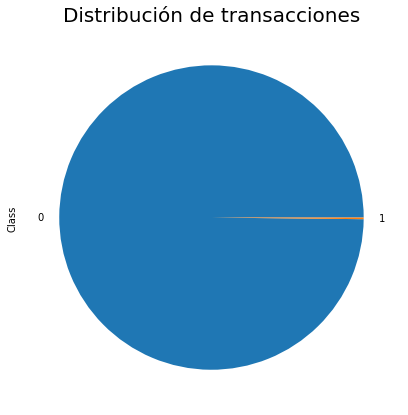

In [5]:
XY['Class'].value_counts().plot(kind='pie', figsize=(7,7))
_ = plt.title('Distribución de transacciones', fontsize=20)

Como vemos, las clases están muy desbalanceadas ya que apenas hay casos fraudulentos. 

# Division en features X + target Y 

In [6]:
X = XY.drop('Class', axis=1)
Y = XY['Class']

# Representación del PCA de las clases

In [7]:
df_plt=XY[XY['Class']==0].sample(2000)
df_plt_pos=XY[XY['Class']==1].sample(20)
df_plt=pd.concat([df_plt,df_plt_pos])
y_plt=df_plt['Class']
X_plt=df_plt.drop('Class',axis=1)

In [8]:
pca2 = PCA(n_components=3)
X_PCA = pca2.fit_transform(X_plt)

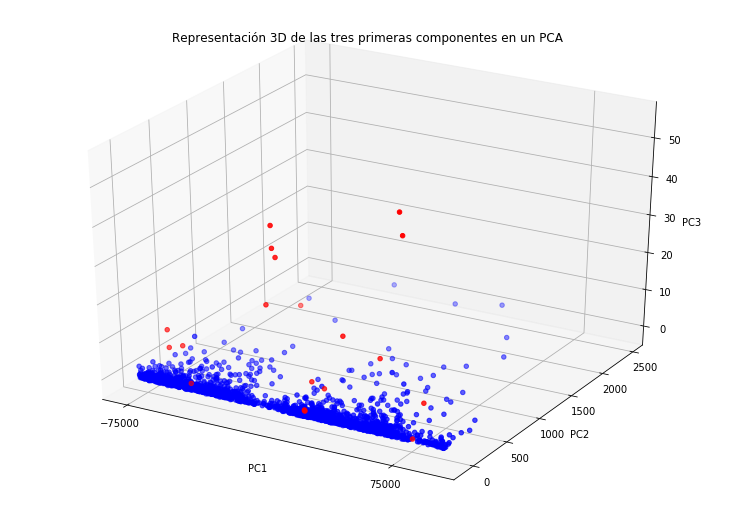

In [9]:
fig = plt.figure(figsize=(10,7))
ax = Axes3D(fig)
ax.scatter(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2], c=y_plt, cmap=plt.cm.get_cmap("bwr"))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([-75000,75000])
ax.set_title('Representación 3D de las tres primeras componentes en un PCA')
plt.show()

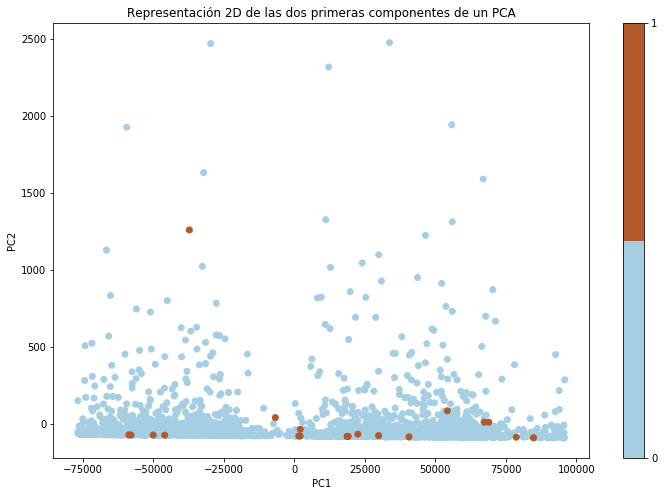

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y_plt, cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))
plt.title('Representación 2D de las dos primeras componentes de un PCA')
plt.xlabel('PC1'); _=plt.ylabel('PC2')

# Ajuste del modelo de detección de anomalías a X

Voy a utilizar el método Local Outlier Factor. Este método sólo se fija en los vecinos locales de cada punto por lo que vamos a ajustar el modelo a todos los datos X. 

Un parámetro que se puede ir cambiando es el **número de vecinos**. A menor número más se ajusta el modelo.

In [11]:
clf=LocalOutlierFactor(n_neighbors=10, 
                        algorithm='auto', 
                        leaf_size=30,
                        metric='minkowski', 
                        p=2, 
                        metric_params=None, 
                        n_jobs=-1,
                        novelty=False)

In [12]:
%%time
clf.fit(X)

Wall time: 2min 5s


LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=-1,
                   n_neighbors=10, novelty=False, p=2)

# Detección de anomalías

El modelo nos proporciona lo que se denominan factores de anomalías negativos. Cuanto más alto es este valor, más normal es el punto. Es decir, si queremos quedarnos con el 2 % de puntos más anómalos, debemos quedarnos con el 2 % de valores más bajo. 

In [13]:
factores_lof = clf.negative_outlier_factor_
factores_lof

array([-1.19618609, -1.15222336, -1.61787169, ..., -1.32806678,
       -1.24067803, -1.75327498])

Ponemos el umbral en un 2 % para tener margen.

In [14]:
Y_pred_clase = factores_lof.copy()
Y_pred_clase[factores_lof>=np.percentile(factores_lof,2.)] = 0
Y_pred_clase[factores_lof<np.percentile(factores_lof,2.)] = 1

La AUC de la ROC es de: 0.67
La F1 es de: 0.06

Accuracy	0.98
Sensitividad	0.358
Precisión	0.031


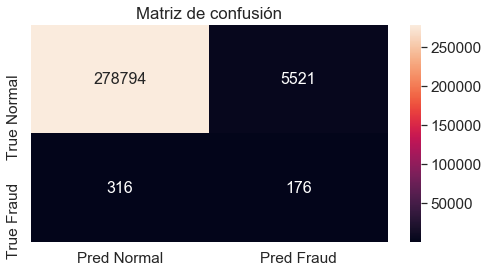

In [15]:
 reporting_modelo(Y, Y_pred_clase) 

Como vemos, con un dos por ciento de la muestra detectada como fraude, detectamos más del 50 % de las transacciones fraudulentas.

## Representación de las probabilidades:

Normalizo los factores al rango (0,1) para obtener una estimación de probabilidades:

In [16]:
Y_probs = NormalizeData(factores_lof)
Y_pred_prob_pos = NormalizeData(factores_lof)[np.where(Y == 1)]
Y_pred_prob_neg = NormalizeData(factores_lof)[np.where(Y == 0)]

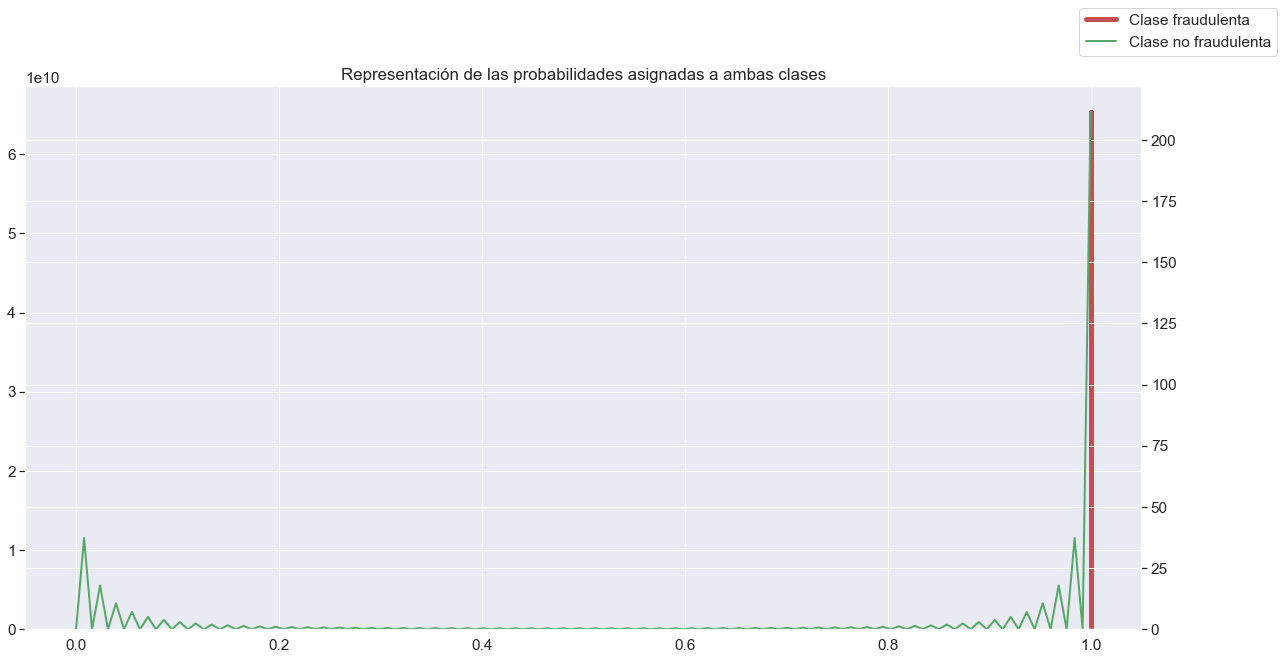

In [17]:
repres_doble_hist(Y_pred_prob_pos, Y_pred_prob_neg)

El modelo asigna a la clase fraudulenta valores centrados en el 1 (anómalos). Por otro lado, la clase no fraudulenta tiene muchos valores en 0s y en 1s. 

## Representación de la ganancia a no tener modelo:

En este punto analizamos qué mejora nos da el modelo. Es decir, que ventaja tiene una empresa usando un modelo de detección de anomalías a no usarlo.

Creo un array con una estimación de probabilidades de 1s y de 0s (tengo las de 1s, simplemente hay que crear otra como $P_0 = 1-P_1$

In [18]:
Y_probs_1_0 = np.column_stack((Y_probs,list(map(lambda x: 1-x, Y_probs))))
Y_probs_1_0

array([[1.00000000e+00, 5.51059198e-12],
       [1.00000000e+00, 4.68358685e-12],
       [1.00000000e+00, 1.34428024e-11],
       ...,
       [1.00000000e+00, 7.99127431e-12],
       [1.00000000e+00, 6.34747810e-12],
       [1.00000000e+00, 1.59897651e-11]])

Podemos representar la ganancia acumulada que obtenemos entre tener modelo y no tenerlo:

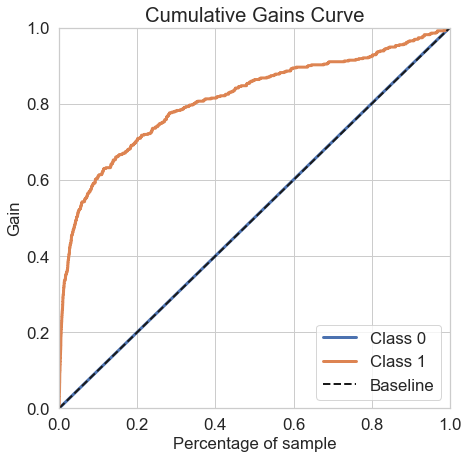

In [19]:
skplt.metrics.plot_cumulative_gain(Y, Y_probs_1_0, figsize=(7,7))
plt.show()

Y la curva de Lift, que es muy usada en los modelos de clasificación, ya que nos indica para cada porcentaje de las transacciones más probables de ser fraude cuál es la ganancia que obtenemos con el modelo. En este caso, si cogemos al 10 % de más transacciones más probables, mejoramos a una decisión aleatoria en un 1000 % aproximadamente.

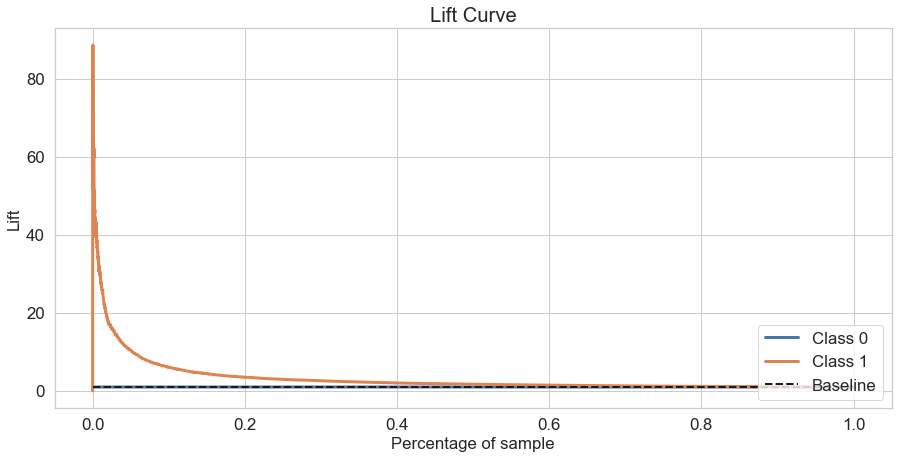

In [20]:
skplt.metrics.plot_lift_curve(Y, Y_probs_1_0, figsize=(15,7))
plt.show()

En este punto, la empresa simplemente auditando un pequeño porcentaje de todas las transacciones totales, daría con la mayoría de las transacciones fraudulentas. Esto ahorraría tiempo y esfuerzo por muchos trabajadores, los cuales podrían dedicarse a otras tareas. 

Más detalles sobre estas gráfica aquí http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html